In [12]:
import astropy
from astropy.io import fits
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import glob

In [4]:
def write_nparr_to_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)
    hdulist.close()
    
def convert_csv_to_fits(csv_file, fits_file, delimiter):
    try:
        # Charge les données à partir du fichier CSV
        result = np.genfromtxt(csv_file, delimiter=delimiter)

        # Vérifie si le tableau a au moins une ligne
        if result.size == 0:
            print(f"Warning: {csv_file} is empty.")
            return

        # S'assurer que le tableau a plus d'une colonne
        if result.shape[1] <= 1:
            print(f"Warning: {csv_file} does not have enough columns.")
            return

        result = np.flip(result)
        write_nparr_to_fits(result, fits_file)
        #print(f"Converted {csv_file} to {fits_file}")
    except Exception as e:
        print(f"Error converting {csv_file}: {e}")


def convert_all_csv_in_directory(input_dir, output_dir, delimiter):
    # Vérifie si le répertoire de sortie existe, sinon le crée
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Parcours tous les fichiers dans le répertoire d'entrée
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            csv_file_path = os.path.join(input_dir, filename)
            fits_file_path = os.path.join(output_dir, filename.replace('.csv', '.fits'))
            convert_csv_to_fits(csv_file_path, fits_file_path, delimiter)
    print(f"✅ Converted all CSV files from {input_dir} to {output_dir}")

In [6]:
input_directory = "code_dft/data/output/small/"
output_directory = "code_dft/data/fits/"
delimiter = ","

convert_all_csv_in_directory(input_directory, output_directory, delimiter)

✅ Converted all CSV files from code_dft/data/output/small/ to code_dft/data/fits/


In [7]:
# Affiche une image FITS sur un subplot donné avec stats et barre de couleur
def display_fits_image(ax, fits_file):
    with fits.open(fits_file) as hdulist:
        data = hdulist[0].data

    if data is not None and np.isfinite(data).any():
        # Nettoyage : on remplace les valeurs non finies par des zéros (ou on les masque)
        data_clean = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

        im = ax.imshow(data_clean, cmap='viridis', origin='lower')
        mean_val = np.mean(data_clean)
        std_val = np.std(data_clean)
        max_val = np.max(data_clean)
        max_pos = np.unravel_index(np.argmax(data_clean), data_clean.shape)
        stats_text = f"mean={mean_val:.2e}\nstd={std_val:.2e}\nmax={max_val:.2e}\nmax_pos={max_pos}"
        ax.set_title(os.path.basename(fits_file), fontsize=8)
        ax.text(0.01, 0.99, stats_text, fontsize=6, color='white',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round'))
        ax.axis('off')
        return im
    else:
        ax.text(0.5, 0.5, "Invalid or empty data", fontsize=6,
                ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
        return None

# Affiche une grille d'images FITS par type (ligne) et par cycle (colonne)
def display_images_by_type(base_dir, types):
    fig, axs = plt.subplots(len(types), NUM_MAJOR_CYCLE, figsize=(15, 3 * len(types)))
    axs = np.array(axs)  # S'assurer que axs est un tableau NumPy 2D
    if axs.ndim == 1:
        axs = axs.reshape(1, -1)

    for row, image_type in enumerate(types):
        files = sorted(glob.glob(os.path.join(base_dir, f"*_{image_type}.fits")))
        for col in range(NUM_MAJOR_CYCLE):
            if col < len(files):
                im = display_fits_image(axs[row][col], files[col])
                if im is not None:
                    cbar = fig.colorbar(im, ax=axs[row][col], fraction=0.046, pad=0.04)
                    cbar.ax.tick_params(labelsize=6)
            else:
                axs[row][col].axis('off')

    plt.tight_layout()
    plt.show()

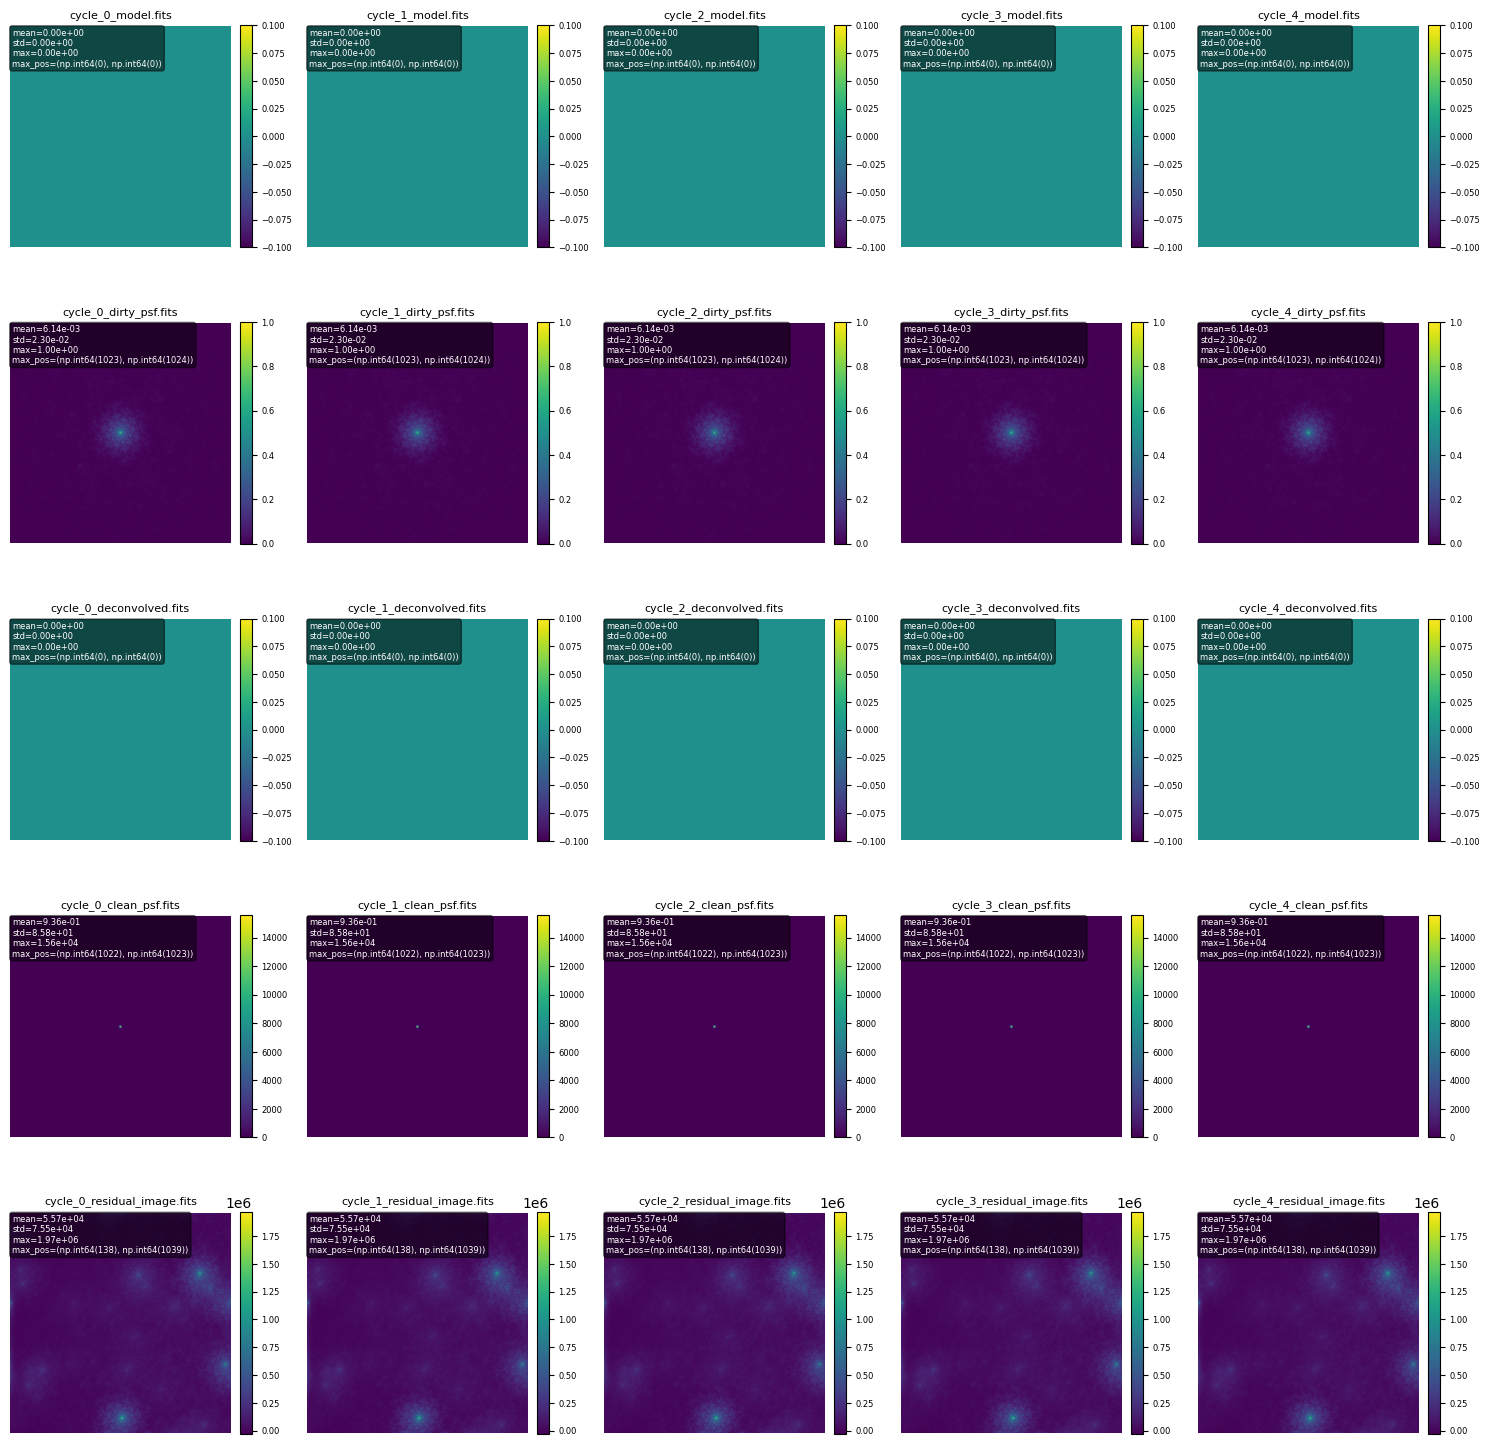

In [13]:
NUM_MAJOR_CYCLE = 5  # Nombre de colonnes (cycles majeurs)

base_dir = 'code_dft/data/fits'
types = ['model', 'dirty_psf', 'deconvolved', 'clean_psf', 'residual_image']

display_images_by_type(base_dir, types)